# Ultrasound Segmentation

In [1]:
import os, glob,  cv2
import numpy as np
from progress_bar import log_progress

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras import backend as K

Using TensorFlow backend.


In [2]:
TRAIN_DIR = 'C:/Users/apriyesh/Desktop/COVID/ultrasound/data/train/'
TEST_DIR = 'C:/Users/apriyesh/Desktop/COVID/ultrasound/data/test/'

# Raw Image Size
IMAGE_ROWS = 420
IMAGE_COLS = 580

# Downsized Image Size
MIN_ROWS = 64
MIN_COLS = 80

train_images = [i for i in os.listdir(TRAIN_DIR) if 'mask' not in i]
test_images =  [i for i in os.listdir(TEST_DIR)]

TRAIN_COUNT = len(train_images)
TEST_COUNT =  len(test_images)

def read_image(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

def read_train():

    train = np.ndarray((TRAIN_COUNT, 1, IMAGE_ROWS, IMAGE_COLS), dtype=np.uint8)
    masks = np.ndarray((TRAIN_COUNT, 1, IMAGE_ROWS, IMAGE_COLS), dtype=np.uint8)

    print('Reading training images...')
    for i, image_file in enumerate(log_progress(train_images)):
        image = read_image(TRAIN_DIR+image_file)
        image = np.array([image])
        train[i] = image 

        mask_file = image_file.split('.')[0] + '_mask.tif'
        mask = read_image(TRAIN_DIR+mask_file)
        mask = np.array([mask])
        masks[i] = mask
        
    print('Train data processed!')
    return train, masks

def read_test():
    
    test = np.ndarray((TEST_COUNT, 1, IMAGE_ROWS, IMAGE_COLS), dtype=np.uint8)
    test_ids = np.ndarray((TEST_COUNT, ), dtype=np.int32)
    print('Reading test images...')
    for i, image_file in enumerate(log_progress(test_images)):
        image_id = int(image_file.split('.')[0])
        image = read_image(TEST_DIR+image_file)
        image = np.array([image])
        test[i] = image  
        test_ids[i] = image_id
        
    
    print('Test data processed!')
    return test, test_ids
    

train, masks = read_train()
test, test_ids = read_test()

Reading training images...


Train data processed!
Reading test images...


Test data processed!


Text(0.5, 1.0, 'Blank Masks vs. Annotated Masks')

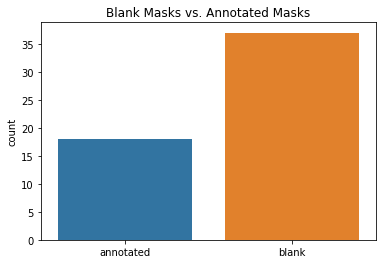

In [4]:
def find_annotated_masks():
    annotations = []
    for mask in masks:
        if np.sum(mask[0]) > 0:
            annotations.append('annotated') # mask present
        else: 
            annotations.append('blank') # mask blank
    return np.array(annotations)

annotations = find_annotated_masks()
sns.countplot(annotations)
plt.title('Blank Masks vs. Annotated Masks')

## Side-by-Side Visual Analysis

Below is a sample of the training images (X) with their masks (y). A visual examination highlights the difficulty indentifying the BP nerve without prior medical training. 

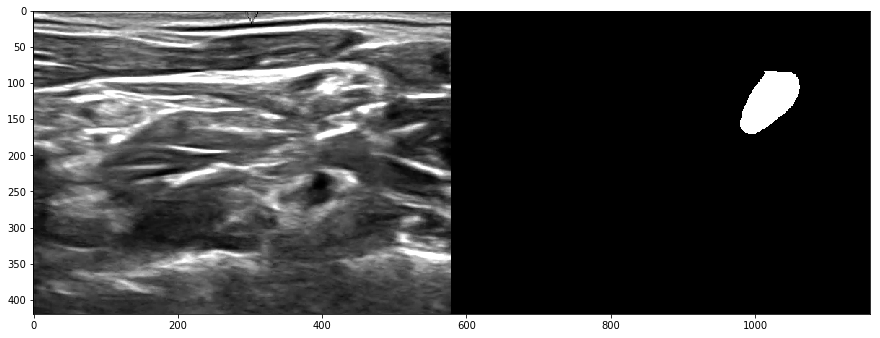

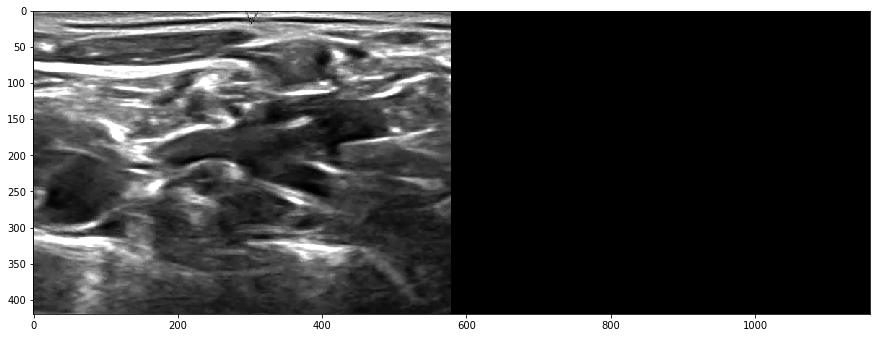

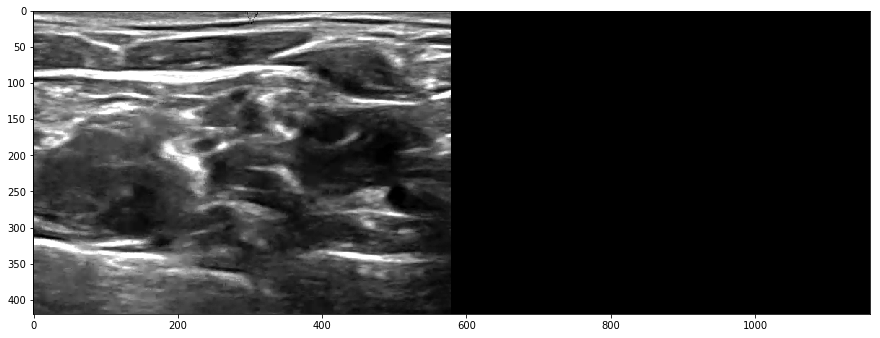

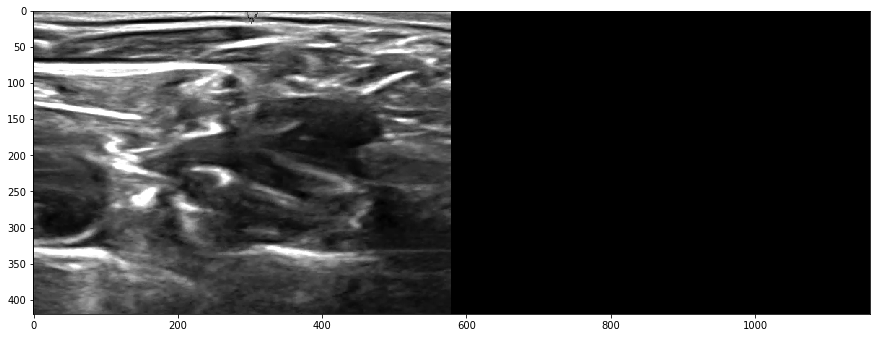

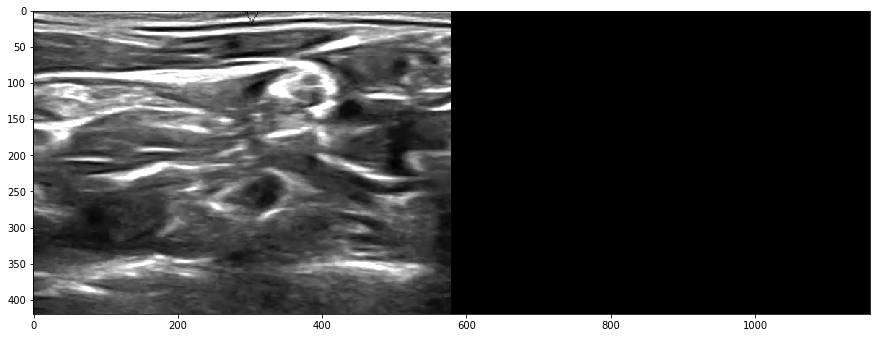

In [5]:
def show_img_with_mask(idx):
    img = train[idx][0]
    mask = masks[idx][0]
    pair = np.concatenate((img, mask), axis=1)
    plt.figure(figsize=(15,20))
    plt.imshow(pair, cmap='gray')
    
for idx in range(0,5):
    show_img_with_mask(idx)

## Average Mask Size


1. The first image shows the average mask arcoss the entire dataset. 

2. The second image provides applies a logrithmic correction to retain the seperation between masks. 

Text(0.5, 1.0, 'Mean Mask Shape')

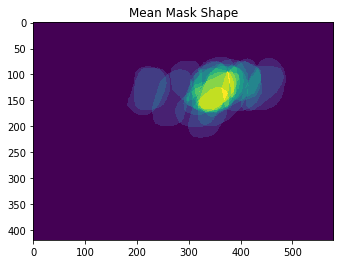

In [6]:
mask_avg = np.array([mask[0] for mask in masks]).mean(axis=0)
plt.imshow(mask_avg, cmap='viridis')
plt.title('Mean Mask Shape')

C:\Users\apriyesh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Log Corrected Mean Mask Shape')

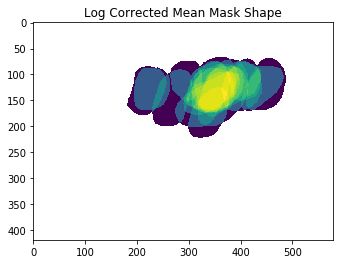

In [7]:
plt.imshow(np.log(mask_avg), cmap='viridis')
plt.title('Log Corrected Mean Mask Shape')

## Pixel Distribution in Sonogram Images

For the training images, it is important to understand the distribution of pixels in the dataset. 

1. Mean pixel distribution across all images.
2. Mean pixel distribution on images with blanks masks.
2. Mean pixel distribution on images with annotated masks.

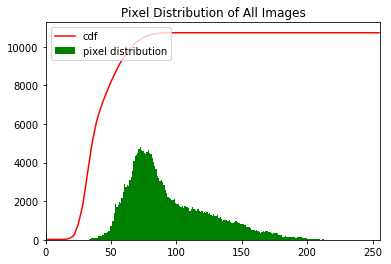

In [8]:
imgs = np.array([img[0] for img in train])
img = imgs.mean(axis=0)

def show_img_hist(img, title):
    hist,bins = np.histogram(img.flatten(),256,[0,580])
    # cumulative distribution function
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    plt.plot(cdf_normalized, color = 'red')
    plt.hist(img.flatten(),256,[0,256], color = 'green')
    plt.xlim([0,256])
    plt.legend(('cdf','pixel distribution'), loc = 'upper left')
    plt.title(title)
    
show_img_hist(img, "Pixel Distribution of All Images")

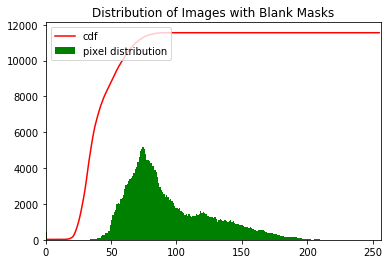

In [9]:
imgs = np.array([img[0] for i, img in enumerate(train) if annotations[i] == 'blank'] )
img = imgs.mean(axis=0)
show_img_hist(img, "Distribution of Images with Blank Masks")

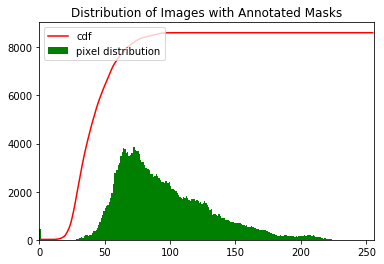

In [10]:
imgs = np.array([img[0] for i, img in enumerate(train) if annotations[i] == 'annotated'] )
img = imgs.mean(axis=0)
show_img_hist(img, "Distribution of Images with Annotated Masks")

## Applying Hisogram Equalization

Balancing the brightness/contrast of the images can be achieved with historgram equalization. The goal is to balance the cumulative distribution function (CDF) into an even slope. Later, this will be applied to each individual image. 

When compared side-by-side, the equalized images are less noisy and maintain better visual serperation between features. 

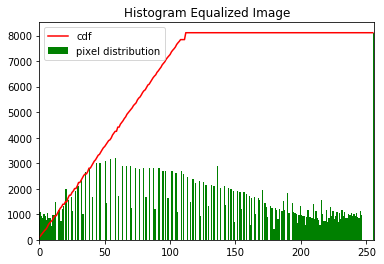

In [11]:
img = train[0, 0] # first image
img = cv2.equalizeHist(img)
show_img_hist(img, "Histogram Equalized Image")

## Preprocessing Decisions and Justification

1. Gaussian Blur - Smooths sharp edges to prevent false poitives.
2. Histogram Equalization - Balances brightness/contast for improved feature detection
3. Resize - Resize to 64x80 to limit number of parameters and memory required for the neural network.


In [14]:
def preprocess(imgs, sonogram=True):
    processed_images = np.ndarray((imgs.shape[0], imgs.shape[1], MIN_ROWS, MIN_COLS), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        img = imgs[i, 0]
        if(sonogram):
            img = cv2.GaussianBlur(img,(7,7),0)
            img = cv2.equalizeHist(img)
        processed_images[i, 0] = cv2.resize(img, (MIN_COLS, MIN_ROWS), interpolation=cv2.INTER_CUBIC)
    processed_images = processed_images.astype('float32') # Float 32 for GPU usage
    return processed_images


train = preprocess(train)


masks = preprocess(masks, sonogram=False)
masks /= 255.0 # converts all mask pixels from 255 to 1


test = preprocess(test)


## Dice Coefficient

In order to calculate the dice coefficient, it is necessary to perform operations on Theano TensorVariables which can be accessed via the backend API in Keras. 

In [15]:
def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)
    return coef

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

# VGG-16 Convolutional Neural Network

Keras implementation of VGG-16, modified for auto-encoding. Specifically, the fully connected dense layers were replaced with upsampling and additional convolutional layers. 

Soruces: 

- [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [16]:
f = 3                       # filter size 3x3
strides = (2, 2)            # strides for pooling/upsampling
optimizer = Adam(lr=1e-5)   # optimizer


def vgg_net():
    input_img = Input((1, MIN_ROWS, MIN_COLS))
    
    c1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(input_img)
    c1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(c1)
    p1 = MaxPooling2D(pool_size=strides)(c1)

    c2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(p1)
    c2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(c2)
    p2 = MaxPooling2D(pool_size=strides)(c2)

    c3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(p2)
    c3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(c3)
    c3 = Convolution2D(128, 1, 1, activation='relu', border_mode='same')(c3)
    p3 = MaxPooling2D(pool_size=strides)(c3)

    c4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(p3)
    c4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(c4)
    c4 = Convolution2D(256, 1, 1, activation='relu', border_mode='same')(c4)
    p4 = MaxPooling2D(pool_size=strides)(c4)

    c5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(p4)
    c5 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(c5)
    c5 = Convolution2D(256, 1, 1, activation='relu', border_mode='same')(c5)
    
    ## Start VGG Modification for auto-encoding
    ## Dense layers repalced with upsampling/convoluions
    
    
    up1 = UpSampling2D(size=(4,4))(c5)
    c6  = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up1)
    c6  = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(c6)
    c6  = Convolution2D(256, 1, 1, activation='relu', border_mode='same')(c6)
    
    up2 = UpSampling2D(size=(4,4))(c6)
    c7  = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up2)     
    c7  = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(c7)
    c7  = Convolution2D(128, 1, 1, activation='relu', border_mode='same')(c7)    

    output = Convolution2D(1, 1, 1, activation='sigmoid')(c7)

    model = Model(input=input_img, output=output)
                      
    model.compile(optimizer=optimizer, 
                  loss=dice_loss, 
                  metrics=[dice])

    return model


model = vgg_net()
model.summary()

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [14]:
nb_epoch = 30
batch_size = 64

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1.]
        self.val_losses = [1.]
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

def run_vgg_net():
    
    history = LossHistory()
    model.fit(train, masks, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.1, verbose=1, shuffle=True, callbacks=[history])

    predictions = model.predict(test, verbose=1) # predicts mask
    return predictions, history

predictions, history = run_vgg_net()

Train on 5071 samples, validate on 564 samples
Epoch 1/30
5071/5071 [==============================] - 48s - loss: 0.9102 - dice: 0.0898 - val_loss: 0.8190 - val_dice: 0.1810
Epoch 2/30
5071/5071 [==============================] - 48s - loss: 0.7497 - dice: 0.2503 - val_loss: 0.7523 - val_dice: 0.2477
Epoch 3/30
5071/5071 [==============================] - 48s - loss: 0.7379 - dice: 0.2621 - val_loss: 0.7443 - val_dice: 0.2557
Epoch 4/30
5071/5071 [==============================] - 48s - loss: 0.6693 - dice: 0.3307 - val_loss: 0.7035 - val_dice: 0.2965
Epoch 5/30
5071/5071 [==============================] - 48s - loss: 0.6303 - dice: 0.3697 - val_loss: 0.6671 - val_dice: 0.3329
Epoch 6/30
5071/5071 [==============================] - 48s - loss: 0.5958 - dice: 0.4042 - val_loss: 0.6243 - val_dice: 0.3757
Epoch 7/30
5071/5071 [==============================] - 48s - loss: 0.5660 - dice: 0.4340 - val_loss: 0.6564 - val_dice: 0.3436
Epoch 8/30
5071/5071 [==============================] - 4

In [ ]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

# U-Net Convolutional Neural Network

Sources:

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)
- [U-Net Keras Adaptation](https://github.com/jocicmarko/ultrasound-nerve-segmentation)

In [13]:
f = 3                       # filter size 3x3
strides = (2, 2)            # strides for pooling/upsampling
optimizer = Adam(lr=1e-5)   # optimizer


def u_net():
    input_img = Input((1, MIN_ROWS, MIN_COLS))
    
    c1 = Convolution2D(32, f, f, activation='relu', border_mode='same')(input_img)
    c1 = Convolution2D(32, f, f, activation='relu', border_mode='same')(c1)
    p1 = MaxPooling2D(pool_size=strides)(c1)

    c2 = Convolution2D(64, f, f, activation='relu', border_mode='same')(p1)
    c2 = Convolution2D(32, f, f, activation='relu', border_mode='same')(c2)
    p2 = MaxPooling2D(pool_size=strides)(c2)

    c3 = Convolution2D(128, f, f, activation='relu', border_mode='same')(p2)
    c3 = Convolution2D(128, f, f, activation='relu', border_mode='same')(c3)
    p3 = MaxPooling2D(pool_size=strides)(c3)

    c4 = Convolution2D(256, f, f, activation='relu', border_mode='same')(p3)
    c4 = Convolution2D(256, f, f, activation='relu', border_mode='same')(c4)
    p4 = MaxPooling2D(pool_size=strides)(c4)

    c5 = Convolution2D(512, f, f, activation='relu', border_mode='same')(p4)
    c5 = Convolution2D(512, f, f, activation='relu', border_mode='same')(c5)

    up6 = merge([UpSampling2D(size=strides)(c5), c4], mode='concat', concat_axis=1)
    c6 = Convolution2D(256, f, f, activation='relu', border_mode='same')(up6)
    c6 = Convolution2D(256, f, f, activation='relu', border_mode='same')(c6)

    up7 = merge([UpSampling2D(size=strides)(c6), c3], mode='concat', concat_axis=1)
    c7 = Convolution2D(128, f, f, activation='relu', border_mode='same')(up7)
    c7 = Convolution2D(128, f, f, activation='relu', border_mode='same')(c7)

    up8 = merge([UpSampling2D(size=strides)(c7), c2], mode='concat', concat_axis=1)
    c8 = Convolution2D(64, f, f, activation='relu', border_mode='same')(up8)
    c8 = Convolution2D(64, f, f, activation='relu', border_mode='same')(c8)

    up9 = merge([UpSampling2D(size=strides)(c8), c1], mode='concat', concat_axis=1)
    c9 = Convolution2D(32, f, f, activation='relu', border_mode='same')(up9)
    c9 = Convolution2D(32, f, f, activation='relu', border_mode='same')(c9)
    
    output = Convolution2D(1, 1, 1, activation='sigmoid')(c9)

    model = Model(input=input_img, output=output)
                      
    model.compile(optimizer=optimizer, 
                  loss=dice_loss, 
                  metrics=[dice])

    return model


model = u_net()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 64, 80)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 64, 80)    320         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 64, 80)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 32, 40)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [16]:
nb_epoch = 30
batch_size = 64

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1.]
        self.val_losses = [1.]
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        
def run_u_net():
    history = LossHistory()
    
    #### Uncomment for data augmentation. 
#     from keras.preprocessing.image import ImageDataGenerator
    
#     datagen = ImageDataGenerator(
#         rotation_range=0.1,
#         width_shift_range=0.1
#         height_shift_range=0.1)
    
#     model.fit_generator(datagen.flow(train, masks, batch_size=32),
#                     samples_per_epoch=len(train), nb_epoch=nb_epoch, callbacks=[history])
    
    model.fit(train, masks, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.1, verbose=1, shuffle=True, callbacks=[history])

    predictions = model.predict(test, verbose=1) # predicts mask
    return predictions, history

predictions, history = run_u_net()

Train on 5071 samples, validate on 564 samples
Epoch 1/30
5071/5071 [==============================] - 25s - loss: 0.9122 - dice: 0.0878 - val_loss: 0.7627 - val_dice: 0.2373
Epoch 2/30
5071/5071 [==============================] - 25s - loss: 0.7060 - dice: 0.2940 - val_loss: 0.6909 - val_dice: 0.3091
Epoch 3/30
5071/5071 [==============================] - 25s - loss: 0.6371 - dice: 0.3629 - val_loss: 0.6407 - val_dice: 0.3593
Epoch 4/30
5071/5071 [==============================] - 25s - loss: 0.5814 - dice: 0.4186 - val_loss: 0.6113 - val_dice: 0.3887
Epoch 5/30
5071/5071 [==============================] - 25s - loss: 0.5524 - dice: 0.4476 - val_loss: 0.5656 - val_dice: 0.4344
Epoch 6/30
5071/5071 [==============================] - 25s - loss: 0.5214 - dice: 0.4786 - val_loss: 0.5526 - val_dice: 0.4474
Epoch 7/30
5071/5071 [==============================] - 25s - loss: 0.5038 - dice: 0.4962 - val_loss: 0.5381 - val_dice: 0.4619
Epoch 8/30
5071/5071 [==============================] - 2

## Analysis of the U-Net Mask Predictions

- Training: 0.6658
- Validation: 0.604

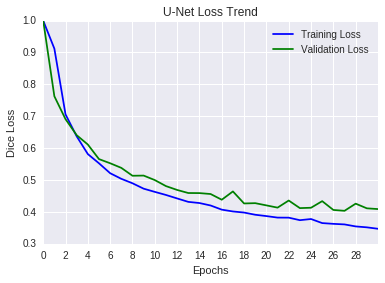

In [17]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.title('U-Net Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

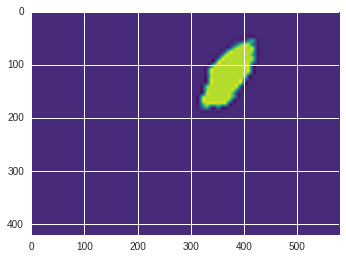

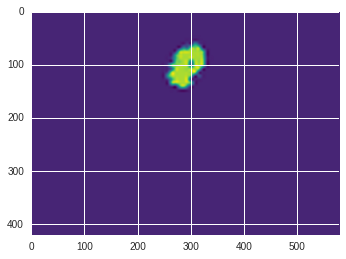

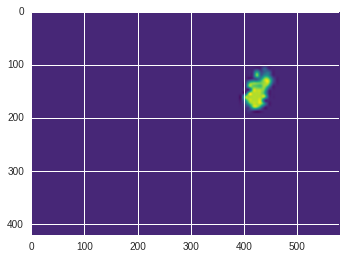

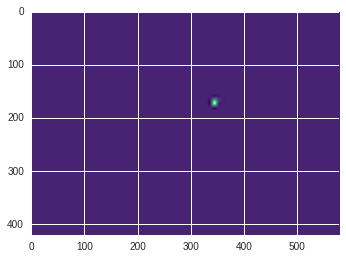

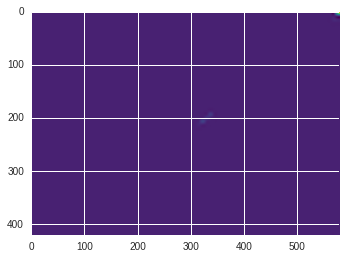

In [16]:
for i in range(0,5):
    pred = predictions[i][0]
    pred = cv2.resize(pred, (IMAGE_COLS, IMAGE_ROWS), interpolation=cv2.INTER_CUBIC)
    plt.imshow(pred, cmap='viridis')
    plt.show()

## Final Processing

Before making a submission, it is necessary to filter out blank masks. Blank masks can be determined by the amount of encoding performed by the neural network. If a predicted mask does not meet a certain threshhold, it will be filtered out by setting all pixel values to zero. 

The training set is slightly unbalanced with only 41% of images having annoations. The threshold will be set equal to the 60th percentile of the sums of the prediction arrays. In other words, only the largest 40% of predicted masks will be retained, while the others will be considered blank. 

In [17]:
prediction_sums = [pred[0].sum() for pred in predictions]
threshold = np.percentile(prediction_sums, 60.0)
print "Filter Threshold set to {0}".format(threshold)

def remove_false_positives(predictions, threshold):   
    for i, pred in enumerate(predictions):    
        if np.sum(pred) < threshold:
            predictions[i][0] = pred * 0

    return predictions

final_predictions = remove_false_positives(predictions, threshold)
print "Filtering Complete!"

Filter Threshold set to 57.3662002563
Filtering Complete!


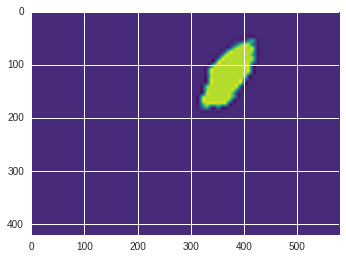

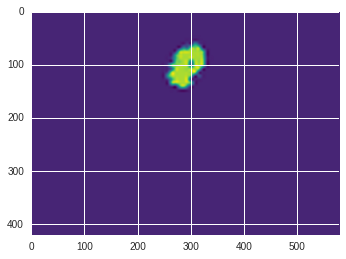

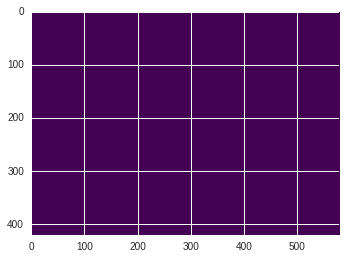

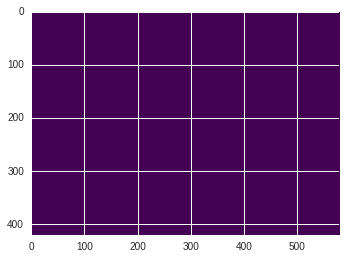

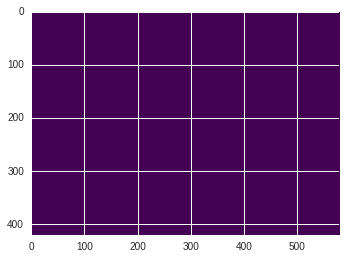

In [18]:
for i in range(0,5):
    pred = final_predictions[i][0]
    pred = cv2.resize(pred, (IMAGE_COLS, IMAGE_ROWS), interpolation=cv2.INTER_CUBIC)
    plt.imshow(pred, cmap='viridis')
    plt.show()